<a href="https://colab.research.google.com/github/oimartin/dog_cat_redux_kernelED/blob/main/reading_in_image_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

## Libraries

In [33]:
import os, cv2, random, shutil
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.output import eval_js
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

# from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassPredictionError
# from yellowbrick.style import set_palette

from sklearn.model_selection import train_test_split
from time import time
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from sklearn.metrics import accuracy_score, f1_score, roc_curve, recall_score, precision_score


## Load Data with Kaggle API
[*Kaggle API doc*](https://www.kaggle.com/general/74235)

In [2]:
eval_js('google.colab.output.setIframeHeight("500")')

uploaded = files.upload()
!mkdir /root/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!mkdir train_img
!mkdir test_img
!unzip train.zip -d train_img
!unzip test.zip -d test_img/

Streaming output truncated to the last 5000 lines.
  inflating: test_img/test/5499.jpg  
  inflating: test_img/test/55.jpg    
  inflating: test_img/test/550.jpg   
  inflating: test_img/test/5500.jpg  
  inflating: test_img/test/5501.jpg  
  inflating: test_img/test/5502.jpg  
  inflating: test_img/test/5503.jpg  
  inflating: test_img/test/5504.jpg  
  inflating: test_img/test/5505.jpg  
  inflating: test_img/test/5506.jpg  
  inflating: test_img/test/5507.jpg  
  inflating: test_img/test/5508.jpg  
  inflating: test_img/test/5509.jpg  
  inflating: test_img/test/551.jpg   
  inflating: test_img/test/5510.jpg  
  inflating: test_img/test/5511.jpg  
  inflating: test_img/test/5512.jpg  
  inflating: test_img/test/5513.jpg  
  inflating: test_img/test/5514.jpg  
  inflating: test_img/test/5515.jpg  
  inflating: test_img/test/5516.jpg  
  inflating: test_img/test/5517.jpg  
  inflating: test_img/test/5518.jpg  
  inflating: test_img/test/5519.jpg  
  inflating: test_img/test/552.jpg   

# EDA
*Inspired by Jeff Delaney notebook: https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter*

## First Look at Data


In [3]:
"""
Get directory path for all images, just dogs, and just cats
"""
def get_images (directory, type=None):
    if type is None:
        images = [directory + i for i in os.listdir(directory)]
        print(f"There are {len(images)} images")
    else:
        images = [directory + i for i in os.listdir(directory) if type in i]
        print(f"There are {len(images)} {type} images")
    return images

train = '/content/train_img/train/'
test = '/content/test_img/test/'

train_images = get_images(train)
train_dogs = get_images(train, 'dog')
train_cats = get_images(train, 'cat')

test_images = get_images(test)

There are 25000 images
There are 12500 dog images
There are 12500 cat images
There are 12500 images


## Sectioning Data

In [4]:
# Randomly select dog and cat images to make subset of training images
train_images = random.sample(train_dogs, 1200) + random.sample(train_cats, 1200)
random.shuffle(train_images)
hmm = train_images[1]
display(hmm[24:])
!mkdir train_subset
for file in train_images:
    shutil.copy(file, f"/content/train_subset/{file[24:]}")

'/cat.4980.jpg'

In [5]:
# Define parameters for images to be processed
ROWS = 150
COLS = 150
CHANNELS = 3

In [51]:
"""
View image and process image for model

"""
def read_image (file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return (cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC))

def prep_data(images):
    count = len(images)
    data = np.ndarray((count,CHANNELS, ROWS, COLS), dtype=np.uint8)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print (f"Processed {i} of {count}")
    return data

train = prep_data(train_images)
print(f"Train shape {train.shape}")

Processed 0 of 2400
Processed 250 of 2400
Processed 500 of 2400
Processed 750 of 2400
Processed 1000 of 2400
Processed 1250 of 2400
Processed 1500 of 2400
Processed 1750 of 2400
Processed 2000 of 2400
Processed 2250 of 2400
Train shape (2400, 3, 150, 150)


## First View of Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.XTick at 0x7f4d8b70ab50>,
 [Text(0, 0, 'Dog_pic'), Text(0, 0, 'Cat_pic')])

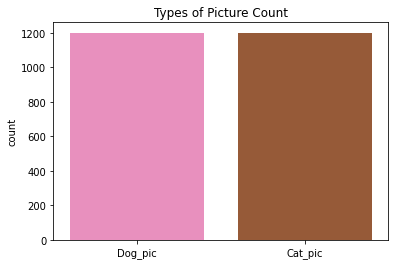

In [7]:
# Create cat/dog label list
labels = []
for img_name in train_images:
    if 'dog' in img_name:
        labels.append(1)
    else:
        labels.append(0)

# View label distribution
sns.set_palette('Set1_r')
sns.countplot(labels).set(title='Types of Picture Count')
plt.xticks(ticks=[0,1], labels=['Dog_pic', 'Cat_pic'])

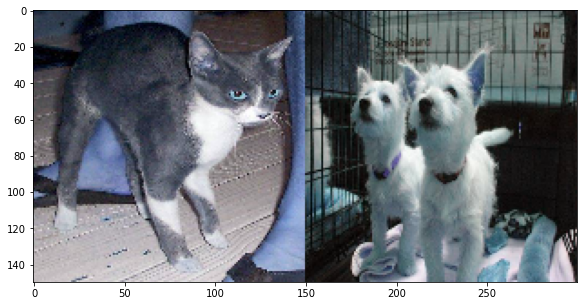

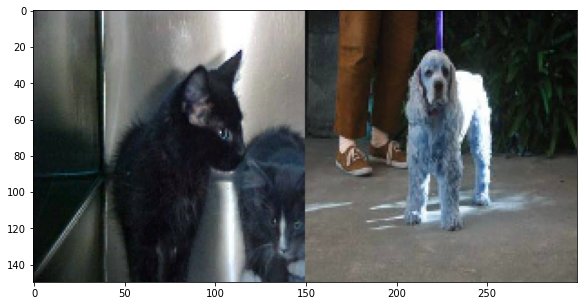

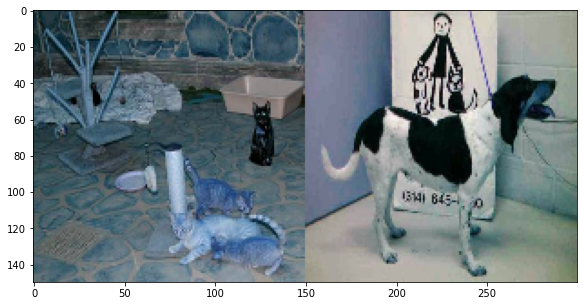

In [54]:
from matplotlib import cm
"""
Display images next to each other for certain cat and dog
"""
def show_cats_and_dogs(no):
  cat = read_image(train_cats[no])
  dog = read_image(train_dogs[no])
  pair = np.concatenate((cat, dog), axis=1)
  plt.figure(figsize=(10,5))
  plt.imshow(pair, cmap='gray')
  plt.show()
  return
  
for img_id in range(6,9):
    show_cats_and_dogs(img_id)

Text(0.5, 1.0, 'Your Average Dog')

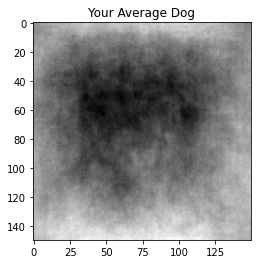

In [55]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg, cmap='gray')
plt.title('Your Average Dog')

Text(0.5, 1.0, 'Your Average Cat')

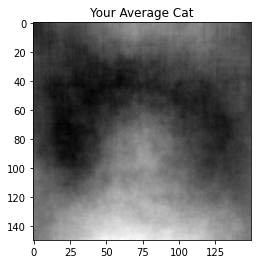

In [56]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg, cmap='gray')
plt.title('Your Average Cat')

# Split Data

In [57]:
X_train, X_test, labels_train, labels_test = train_test_split(train,
                                                                labels,
                                                                test_size=0.2,
                                                                random_state=22)

print(f'''X_train shape {X_train.shape}
labels_train shape {len(labels_train)}
X_test shape {X_test.shape}
labels_test {len(labels_test)}
''')

X_train shape (1920, 3, 150, 150)
labels_train shape 1920
X_test shape (480, 3, 150, 150)
labels_test 480



In [58]:
X_train = X_train.reshape(1920,150,150,3)
X_test = X_test.reshape(480,150,150,3)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

# CNN Models

### Model Functions

In [82]:
def run_model (model, model_name):
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 

  start = time()
  fitted_model = model.fit(X_train,
                           labels_train,
                           batch_size=16)
  end = time()
  runtime = round((end-start), 4)
  print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return runtime

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  return pred

def evaluating_model (y_true, y_pred, model_name, train_test, runtime):
  df=pd.DataFrame({ 'model_name': [model_name, model_name, 
                                   model_name, model_name,
                                   model_name],
                   'type': [train_test, train_test,
                            train_test, train_test,
                            train_test],
                   'metric_name': ["accuracy","f1",'recall',
                                   'precision', 'runtime_min'],
                   'metric' : [round(accuracy_score(y_true, y_pred),4),
                               round(f1_score(y_true, y_pred, average='micro'),4),
                               round(recall_score(y_true, y_pred, average='micro'), 4),
                               round(precision_score(y_true, y_pred, average='micro'), 4),
                               round((runtime/60),4)]})
  display(df)
  return df

def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')
  return

def submitted (fitted_model, model_name, test=test):
  pred = fitted_model.predict(test)
  df = pd.DataFrame(pred).rename(columns={0: 'label'}).astype('int64')
  df.index += 1
  df['id'] = df.index
  df = df[['id', 'label']]
  df.to_csv(f"{model_name}_pred.csv", index=False)
  return df

### Test Data

In [53]:
eval_js('google.colab.output.setIframeHeight("100")')


test = prep_data(test_images)
print(f"Test shape {test.shape}")

Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Processed 4750 of 12500
Processed 5000 of 12500
Processed 5250 of 12500
Processed 5500 of 12500
Processed 5750 of 12500
Processed 6000 of 12500
Processed 6250 of 12500
Processed 6500 of 12500
Processed 6750 of 12500
Processed 7000 of 12500
Processed 7250 of 12500
Processed 7500 of 12500
Processed 7750 of 12500
Processed 8000 of 12500
Processed 8250 of 12500
Processed 8500 of 12500
Processed 8750 of 12500
Processed 9000 of 12500
Processed 9250 of 12500
Processed 9500 of 12500
Processed 9750 of 12500
Processed 10000 of 12500
Processed 10250 of 12

In [84]:
test_subset = test[:25]


## Model 1

In [61]:
cnn1 = Sequential([
    layers.Conv2D(200, kernel_size=3, activation='relu',
                  input_shape=(ROWS, COLS,3)),
    layers.Conv2D(100, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation="softmax"),
])
cnn1.compile(optimizer="adam", loss="binary_crossentropy",
                    metrics=['accuracy'])

In [62]:
cnn1_rt = run_model(cnn1, 'cnn_2d21_d105')
train_pred_cnn1 = prediction(cnn1, X_train)
test_pred_cnn1 = prediction(cnn1, X_test)

120/120 [==============================] - 1037s 9s/step - loss: 71.2501 - accuracy: 0.5016
cnn_2d21_d105 took 1042.4685 seconds or 17.3745 minutes to run.


### Evaluate First CNN Model

In [63]:
cnn1_train = evaluating_model(labels_train, train_pred_cnn1, 'cnn1', 'Train', 900)
eval_classification(train_pred_cnn1, labels_train, X_train, 'cnn1', 'Train')
print("---------------------")
cnn1_test = evaluating_model(labels_test, test_pred_cnn1, 'cnn1', 'Test', 900)
eval_classification(test_pred_cnn1, labels_test, X_test, 'cnn1', 'Test')

,model_name,type,metric_name,metric
0,cnn1,Train,accuracy,0.5016
1,cnn1,Train,f1,0.5016
2,cnn1,Train,recall,0.5016
3,cnn1,Train,precision,0.5016
4,cnn1,Train,runtime_min,15.0000



  cnn1 for Train Data
  FPR [0. 1.]
  TPR [0. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,cnn1,Test,accuracy,0.4938
1,cnn1,Test,f1,0.4938
2,cnn1,Test,recall,0.4938
3,cnn1,Test,precision,0.4938
4,cnn1,Test,runtime_min,15.0000



  cnn1 for Test Data
  FPR [0. 1.]
  TPR [0. 1.]
  


### Actual Test Results

In [67]:
submitted(cnn1, 'cnn1', test.reshape(12500, 150, 150, 3))

,Label,ImageId
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
...,...,...
12496,1,12496
12497,1,12497
12498,1,12498
12499,1,12499


In [80]:
sub = pd.read_csv('cnn1_pred.csv')
sub = sub.rename(columns={'Label':'label',
                    'ImageId':'id'})
sub = sub[['id', 'label']]
sub.to_csv('cnn1_pred_y.csv', index=False)

In [79]:
sub

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
12495,12496,1
12496,12497,1
12497,12498,1
12498,12499,1
